In [1]:
import jax.random as jr 
import jax.numpy as jnp
import dill
import os
import gymnax
import equinox as eqx
import matplotlib.pyplot as plt

from reinforce import visualize_trajectory, rollout_parallel

name = 'charlie'
with open(f'../weights/dynamics/{name}.pkl', 'rb') as file:
    dynamics = dill.load(file)
with open(f'../weights/policy/{name}.pkl', 'rb') as file:
    policy = dill.load(file)

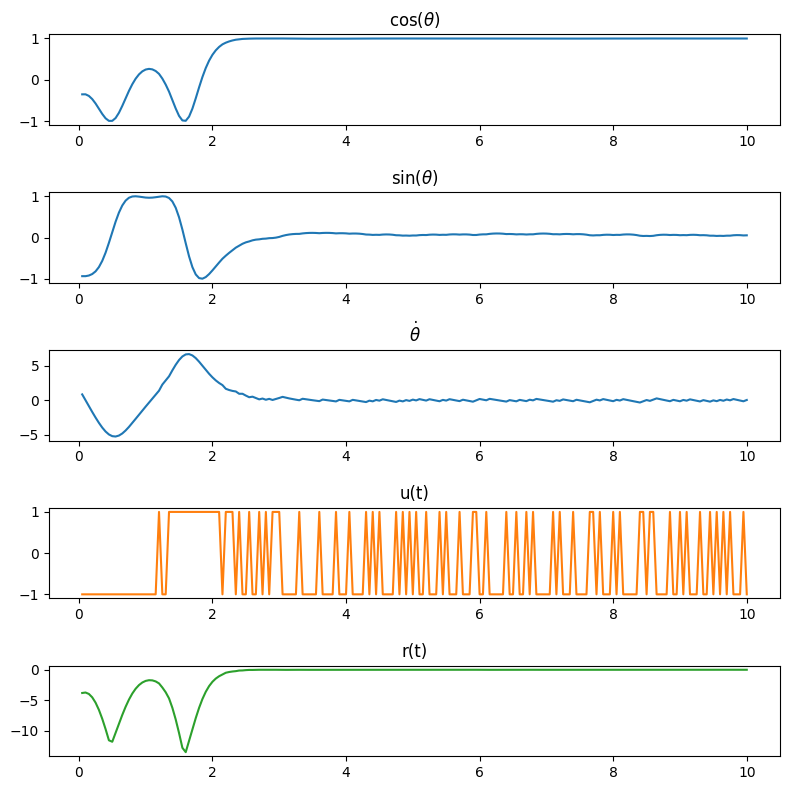

In [2]:
SEED = 0 
key_vis, key_rollout = jr.split(jr.PRNGKey(SEED), 2)
env, env_params = gymnax.make('Pendulum-v1')

policy_params, policy_static = eqx.partition(policy, eqx.is_inexact_array)
keys_rollout = jr.split(key_rollout, 2)
obss, actionss, rewardss, _, _= rollout_parallel(keys_rollout, policy_params, policy_static, env_params)
ts = jnp.linspace(0, env_params.dt * env_params.max_steps_in_episode, env_params.max_steps_in_episode)
# Return data
pred_obss = dynamics(ts, obss[0, 0, :], actionss[0, :])


visualize_trajectory(policy, env, env_params, key_vis)


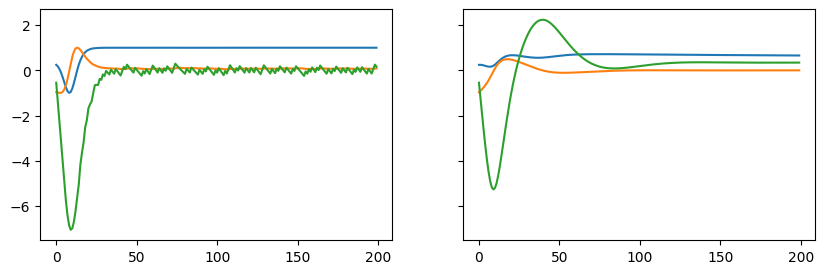

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
axes[0].plot(obss[0])
axes[1].plot(pred_obss)

In [4]:
from helpers import rollout_parallel
def select_action_mpc(key, horizon, rollout_batch_size, *, 
                      model_params, model_static, dynamics):

    # Get trajectories
    keys_rollout = jr.split(key, rollout_batch_size)
    obs = dynamics()

    # Selection criteria
    final_rewards = rewardss[:, -1]
    print(final_rewards)

    # Selection action
    

In [5]:
import jax
from functools import partial as pt

def get_init_obs(key):
    high = jnp.array([jnp.pi, 1])
    init_state = jr.uniform(key, shape=(2,), minval=-high, maxval=high)
    init_obs = jnp.array([
        jnp.cos(init_state[0]),
        jnp.sin(init_state[0]),
        init_state[1],
        ])
    return init_obs

def get_action(obs, key, model):
    ACTIONS = jnp.array([-1, 0, 1])
    return jr.choice(key, ACTIONS, p=model(obs))

def get_reward(obs, u):
    theta = jnp.arctan2(obs[1], obs[0])
    theta_dot = obs[2]
    reward = -(
        angle_normalize(theta) ** 2
        + 0.1 * theta_dot ** 2
        + 0.001 * (u ** 2)
    )
    reward = reward.squeeze()
    return reward

def angle_normalize(x: float) -> float:
    """Normalize the angle - radians."""
    return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi

eqx.filter_jit
def rollout_ode(key, model, environment_ode, env_params, steps_in_episode=None):
    """Rollout a jitted gymnax episode with lax.scan."""

    def policy_step(carry, vars, env_ode, policy, ts):
        """lax.scan compatible step transition in jax env."""
        obs = carry
        
        key_step, key_net = jr.split(key, 2)
        action = pt(get_action, model=policy)(obs, key_net)
        next_obs = env_ode(ts, obs, jnp.expand_dims(action, axis=0))[1, :]
        reward = get_reward(next_obs, action)
        carry = next_obs
        return carry, [obs, action, reward]

    key_reset, rng_episode = jr.split(key, 2)
    # Init the environment
    init_obs = get_init_obs(key_reset)
    if steps_in_episode is None:
        steps_in_episode = env_params.max_steps_in_episode

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      pt(policy_step, env_ode=environment_ode, policy=model, ts=jnp.array([0, env_params.dt])),
      init_obs,
      (),
      steps_in_episode
    )
    
    obs, action, reward, = scan_out
    return obs, action, reward


In [6]:
obs, actions, rewards = rollout_ode(key_rollout, policy, dynamics, env_params)

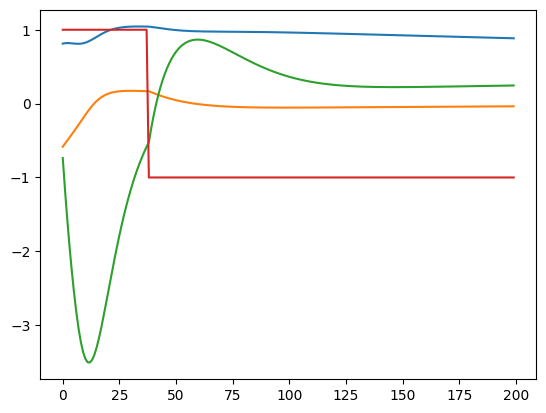

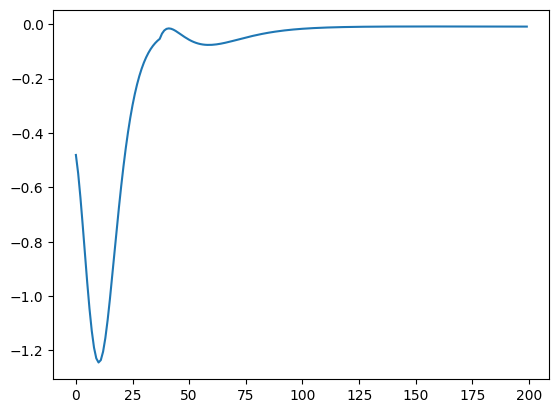

In [7]:
plt.plot(obs)
plt.plot(actions)
plt.show()
plt.plot(rewards)

In [8]:
from functools import partial

def make_rollout_env(environment_params):
    if "gymnax" in str(type(environment_params)):
        env, _ = gymnax.make('Pendulum-v1')

    return env

def rollout(key, model_params, model_static, env_params, steps_in_episode=None):
    """Rollout a jitted gymnax episode with lax.scan."""

    def get_action(obs, key):
      ACTIONS = jnp.array([-1, 0, 1])
      return jr.choice(key, ACTIONS, p=model(obs))

    def policy_step(state_input, tmp, env):
        """lax.scan compatible step transition in jax env."""
        obs, state, rng = state_input
        rng, rng_step, rng_net = jax.random.split(rng, 3)
        action = get_action(obs, rng_net)

        next_obs, next_state, reward, done, _ = env.step(
          rng_step, state, action, env_params
        )

        carry = [next_obs, next_state, rng]
        return carry, [obs, action, reward, state, next_obs, done]

    rng_reset, rng_episode = jax.random.split(key, 2)
    # Init the environment
    env = make_rollout_env(env_params)
    obs, state = env.reset(rng_reset, env_params)
    # Combine model
    model = eqx.combine(model_params, model_static)

    if steps_in_episode is None:
        steps_in_episode = env_params.max_steps_in_episode

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      partial(policy_step, env=env),
      [obs, state, rng_episode],
      (),
      steps_in_episode
    )
    
    # Return masked sum of rewards accumulated by agent in episode
    obs, action, reward, state, next_obs, done = scan_out
    return obs, action, reward, state, next_obs, done

In [9]:
import equinox as eqx
import jax

params, static = eqx.partition(policy, eqx.is_inexact_array)
# rollout(key_rollout, params, static)

env, env_params = gymnax.make('Pendulum-v1')
# visualize_trajectory(policy, env, env_params, key_rollout)
obs, action, reward, state, next_obs, done = rollout(key_rollout, params, static, env_params)